In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
#Read the csv file
df = pd.read_csv('data/AAPL.csv')
train_dates = pd.to_datetime(df['date'])


In [3]:

#Variables for training
cols = ['close','volume']

In [4]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

In [5]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [6]:
n_train_days = 52   # Number of days we want to remove from test

X_train = df_for_training_scaled[: df_for_training_scaled.shape[0] - n_train_days] 
X_days =  train_dates[: df_for_training_scaled.shape[0] - n_train_days] 

y_train = df_for_training_scaled[df_for_training_scaled.shape[0] - n_train_days:] 
y_days =  train_dates[df_for_training_scaled.shape[0] - n_train_days:]

In [7]:

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(X_train) - n_future +1):
    trainX.append(X_train[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(X_train[i + n_future - 1:i + n_future, 0])


trainX, trainY = np.array(trainX), np.array(trainY)

In my case, trainX has a shape (12809, 14, 5). 

12809 because we are looking back 14 days (12823 - 14 = 12809). 

Remember that we cannot look back 14 days until we get to the 15th day. 

Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 

it needs multiple variables (5 in my example) to make this prediction. 

This is why we can only predict a single day after our training, the day after where our data ends.

To predict more days in future, we need all the 5 variables which we do not have. 

We need to predict all variables if we want to do that. 



In [8]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 128)           67072     
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 64)            49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 128,929
Trainable params: 128,929
Non-trainable params: 0
_________________________________________________________________


In [9]:
# fit the model
history = model.fit(trainX, trainY, epochs=125, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/125
148/148 [==============================] - 12s 63ms/step - loss: 0.0364 - val_loss: 0.1063
Epoch 2/125
148/148 [==============================] - 9s 62ms/step - loss: 0.0129 - val_loss: 0.2749
Epoch 3/125
148/148 [==============================] - 10s 65ms/step - loss: 0.0109 - val_loss: 3.1375
Epoch 4/125
148/148 [==============================] - 10s 65ms/step - loss: 0.0106 - val_loss: 1.7247
Epoch 5/125
148/148 [==============================] - 10s 67ms/step - loss: 0.0101 - val_loss: 0.3886
Epoch 6/125
148/148 [==============================] - 10s 68ms/step - loss: 0.0094 - val_loss: 0.6507
Epoch 7/125
148/148 [==============================] - 10s 66ms/step - loss: 0.0090 - val_loss: 0.5307
Epoch 8/125
148/148 [==============================] - 10s 67ms/step - loss: 0.0087 - val_loss: 1.2008
Epoch 9/125
148/148 [==============================] - 10s 66ms/step - loss: 0.0090 - val_loss: 1.1376
Epoch 10/125
148/148 [==============================] - 10s 64ms/step - lo

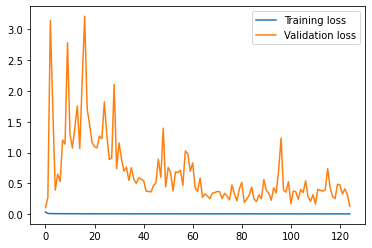

In [10]:

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [11]:

#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# recompute entire data set 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])


trainX, trainY = np.array(trainX), np.array(trainY)


In [12]:
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 201
n_days_for_prediction=200  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [13]:
trainX.shape

(2675, 14, 2)

ipykernel_launcher:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/karim/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/karim/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='date', ylabel='closeadj'>

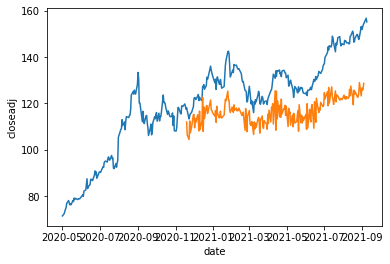

In [14]:

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'closeadj':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])


original = df[['date', 'closeadj']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2020-5-1']

sns.lineplot(original['date'], original['closeadj'])
sns.lineplot(df_forecast['date'], df_forecast['closeadj'])